In [30]:
import allel
import loompy
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter
from collections import defaultdict

from matplotlib_venn import venn2_unweighted, venn2, venn3

import mb_funcs as mb
%load_ext autoreload
%autoreload 2

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# intersection of mutations in primary tumor and the liver metastasis

In [36]:
df_primary = pd.read_csv('data/primary_selected_pos_indices.csv', sep=',')
df_liver_met = pd.read_csv('data/liver_met_selected_pos_indices.csv', sep=',')
df_e1 = pd.read_csv('data/E1_selected_pos_indices.csv', sep=',')

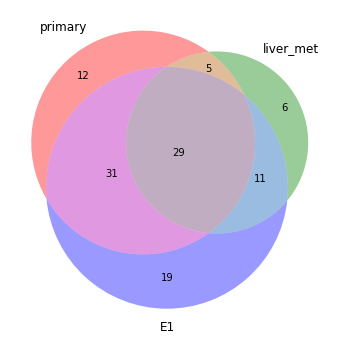

In [39]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
venn3([set(df_primary['pos']), set(df_liver_met['pos']), set(df_e1['pos'])], set_labels=('primary', 'liver_met', 'E1'))
plt.savefig('figures/patient2_snv_venn_diagram.pdf', bbox_inches='tight')